Biometric Systems (2023-2024) Project

**Weidong Cai 1836167**

**Elena Jiang 1846716**

# **Abstract**

The evaluation of this project, a face recognition system, is an open-set identification (1:N) task, as an un-enrolled user can interact with the system. The system can detect whether the user is registered in the system. We use **Deepface**, a lightweight face recognition framework for Python, which is a hybrid face recognition package. In particular, we use the **'GhostFaceNet'** model, as its declared LFW score is the highest.

The dataset used is the **LFW** (Labeled Faces in the Wild), and we use an **all probe templates compared with all gallery templates** approach to evaluate the performance of the model. We use thresholds ranging from 0.01 to 0.99 with a step of 0.01. For each threshold, we calculate the False Acceptance (FA) rate, False Rejection (FR) rate, Detection and Identification Rate (DI), and Genuine Recognition (GR) rate, to evaluate the system's performance comprehensively.

# **1. Dependences**

In [1]:
import os
import re
import json
import keras
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from deepface import DeepFace
from sklearn.metrics import det_curve

# **2. Global Constants**

The dataset used for evaluation is the Labeled Faces in the Wild (LFW).

In [2]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [38]:
# Load the model and the path of the dataset 
model = keras.models.load_model('ghostfacenet_v1.h5')
dataset_dir = 'dataset' # LFW dataset
evaluation_metrics_file = 'evaluation_metrics.json'

In [7]:
# Get the list of persons
entities = [p for p in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, p)) and not p.startswith('.')]
random.shuffle(entities) 
print(f'The dataframe has a total of {len(entities)} entities')

The dataframe has a total of 5749 entities


# **3. Dataset**

## **3.1 Generate Dataframe**

For each image, first check if it contains a human face. If so, the person has more than 3 images, classify them as "Genuine," and select at most 6 valid photos. If the person has 3 or fewer images, classify them as an "Impostor."

In [8]:
data = []
min_num_photo_for_person = 3
max_num_photo_for_person = 6

for person in entities:
    person_dir = os.path.join(dataset_dir, person) # Entity path
    images_path = os.listdir(person_dir) # Entity photos
    random.shuffle(images_path)
    count = 0
    for image in images_path:   
        img_path = os.path.join(person_dir, image)
        result = DeepFace.extract_faces(img_path=img_path, enforce_detection=False)
        # Remove image which can't detect the face
        if result[0]['confidence'] != 0 and count < max_num_photo_for_person:
            if len(images_path) >= min_num_photo_for_person:
                data.append([person, img_path, 'Genuine'])
            else: 
                data.append([person, img_path, 'Impostor'])
        count += 1

In [9]:
df = pd.DataFrame(data, columns=['Person', 'Image_Path', 'Label'])
df.head()

,Person,Image_Path,Label
0,Giuseppe_Gibilisco,dataset/Giuseppe_Gibilisco/Giuseppe_Gibilisco_...,Genuine
1,Giuseppe_Gibilisco,dataset/Giuseppe_Gibilisco/Giuseppe_Gibilisco_...,Genuine
2,Giuseppe_Gibilisco,dataset/Giuseppe_Gibilisco/Giuseppe_Gibilisco_...,Genuine
3,Giuseppe_Gibilisco,dataset/Giuseppe_Gibilisco/Giuseppe_Gibilisco_...,Genuine
4,Diana_Krall,dataset/Diana_Krall/Diana_Krall_0001.jpg,Genuine


In [11]:
print(f'The dataframe has a total of {df.shape[0]} images')
print(f"The dataframe has {(df['Label'] == 'Genuine').sum()} Genuine Probes")
print(f"The dataframe has {(df['Label'] == 'Impostor').sum()} Impostor Probes")

The dataframe has a total of 9378 images
The dataframe has 3925 Genuine Probes
The dataframe has 5453 Impostor Probes


In [12]:
person_genuine = set(df[df['Label'] == 'Genuine']['Person'].tolist())
print(f'The dataframe has a total of {len(person_genuine)} Enrolled entities')

person_impostor = set(df[df['Label'] == 'Impostor']['Person'].tolist())
print(f'The dataframe has a total of {len(person_impostor)} Not Enrolled entities')

The dataframe has a total of 901 Enrolled entities
The dataframe has a total of 4717 Not Enrolled entities


## **3.2 Reduce the entities to 200** 

In [26]:
selected_genuine = random.sample(list(person_genuine), 100)

filtered_df = df[df['Person'].isin(selected_genuine)]
genuine_df = pd.concat([filtered_df, df[df['Label'] == 'Impostor']])

print(f"Total enrolled in the new dataframe: {genuine_df[genuine_df['Label'] == 'Genuine']['Person'].nunique()}")
print(f"The new dataframe has {(genuine_df['Label'] == 'Genuine').sum()} Genuine Probes")

Total enrolled in the new dataframe: 100
The new dataframe has 425 Genuine Probes


In [31]:
selected_impostors = random.sample(list(person_impostor), 100)

filtered_impostor_df = genuine_df[genuine_df['Person'].isin(selected_impostors)]
final_df = pd.concat([filtered_impostor_df, genuine_df[genuine_df['Label'] == 'Genuine']])

print(f"Total impostors in the new dataframe: {final_df[final_df['Label'] == 'Impostor']['Person'].nunique()}")
print(f"Total enrolled in the new dataframe: {final_df[final_df['Label'] == 'Genuine']['Person'].nunique()}")

print(f"The new dataframe has {(final_df['Label'] == 'Genuine').sum()} Genuine Probes and {(final_df['Label'] == 'Impostor').sum()} Impostor Probes")

Total impostors in the new dataframe: 100
Total enrolled in the new dataframe: 100
The new dataframe has 437 Genuine Probes and 115 Impostor Probes


In [4]:
final_df.head()

,Person,Image_Path,Label
0,David_Kelly,lfw_dataset/David_Kelly/David_Kelly_0001.jpg,Impostor
1,Rafeeuddin_Ahmed,lfw_dataset/Rafeeuddin_Ahmed/Rafeeuddin_Ahmed_...,Impostor
2,Elva_Hsiao,lfw_dataset/Elva_Hsiao/Elva_Hsiao_0001.jpg,Impostor
3,Ruth_Dreifuss,lfw_dataset/Ruth_Dreifuss/Ruth_Dreifuss_0001.jpg,Impostor
4,Ruth_Dreifuss,lfw_dataset/Ruth_Dreifuss/Ruth_Dreifuss_0002.jpg,Impostor


In [15]:
final_df.to_csv('image_genuine_impostor.csv', index=False)

# **4. Evaluation ALL-against-ALL approach** 

## **4.1 Generate matrix** 

In [3]:
final_df = pd.read_csv('image_genuine_impostor.csv')

In [33]:
gallery = final_df[final_df['Label'] == 'Genuine']['Image_Path'].tolist() # Column
probes = final_df['Image_Path'].tolist() # Row

print(f"The gallery contains {len(gallery)} templates.")
print(f"There are {len(probes)} probes in total")

The gallery contains 437 templates.
There are 552 probes in total


In [6]:
distances = []

Divide the probes into subsets and run them separately. To calculate the distance between two images, use the Deepface library by calling its function with the GhostFaceNet model.

In [7]:
count = 0
for img2_path in probes[540:550]:
    print("working on the row ", count, img2_path)
    distances_row = []
    for img1_path in gallery:
        result = DeepFace.verify(img1_path=img1_path, img2_path = img2_path, model_name = 'GhostFaceNet')
        distances_row.append(result['distance'])
    distances.append(distances_row)
    count += 1

working on the row  540 lfw_dataset/Laura_Bush/Laura_Bush_0017.jpg
working on the row  541 lfw_dataset/Lucy_Liu/Lucy_Liu_0004.jpg
working on the row  542 lfw_dataset/Lucy_Liu/Lucy_Liu_0001.jpg
working on the row  543 lfw_dataset/Lucy_Liu/Lucy_Liu_0003.jpg
working on the row  544 lfw_dataset/Lucy_Liu/Lucy_Liu_0005.jpg
working on the row  545 lfw_dataset/Lucy_Liu/Lucy_Liu_0002.jpg
working on the row  546 lfw_dataset/Hu_Jintao/Hu_Jintao_0004.jpg
working on the row  547 lfw_dataset/Hu_Jintao/Hu_Jintao_0002.jpg
working on the row  548 lfw_dataset/Hu_Jintao/Hu_Jintao_0003.jpg
working on the row  549 lfw_dataset/Hu_Jintao/Hu_Jintao_0001.jpg


In [10]:
df_distanze = pd.DataFrame(distances, index=probes[540:550], columns=gallery)

In [11]:
df_distanze.head()

,lfw_dataset/John_Warner/John_Warner_0002.jpg,lfw_dataset/John_Warner/John_Warner_0003.jpg,lfw_dataset/John_Warner/John_Warner_0004.jpg,lfw_dataset/John_Warner/John_Warner_0001.jpg,lfw_dataset/Candice_Bergen/Candice_Bergen_0003.jpg,lfw_dataset/Candice_Bergen/Candice_Bergen_0002.jpg,lfw_dataset/Candice_Bergen/Candice_Bergen_0001.jpg,lfw_dataset/Naoto_Kan/Naoto_Kan_0001.jpg,lfw_dataset/Naoto_Kan/Naoto_Kan_0004.jpg,lfw_dataset/Naoto_Kan/Naoto_Kan_0003.jpg,...,lfw_dataset/Lucy_Liu/Lucy_Liu_0001.jpg,lfw_dataset/Lucy_Liu/Lucy_Liu_0003.jpg,lfw_dataset/Lucy_Liu/Lucy_Liu_0005.jpg,lfw_dataset/Lucy_Liu/Lucy_Liu_0002.jpg,lfw_dataset/Hu_Jintao/Hu_Jintao_0004.jpg,lfw_dataset/Hu_Jintao/Hu_Jintao_0002.jpg,lfw_dataset/Hu_Jintao/Hu_Jintao_0003.jpg,lfw_dataset/Hu_Jintao/Hu_Jintao_0001.jpg,lfw_dataset/Hu_Jintao/Hu_Jintao_0014.jpg,lfw_dataset/Hu_Jintao/Hu_Jintao_0006.jpg
lfw_dataset/Laura_Bush/Laura_Bush_0017.jpg,0.752520,0.849843,0.854745,0.882114,0.809179,0.865830,0.853882,0.967927,1.006749,0.929747,...,9.466756e-01,8.204558e-01,8.270963e-01,0.905781,0.926717,0.868164,0.897032,0.945776,0.880382,0.896276
lfw_dataset/Lucy_Liu/Lucy_Liu_0004.jpg,0.924644,0.905922,0.909250,1.000674,0.895732,0.894063,0.948856,1.090310,0.901296,1.057003,...,7.355845e-01,7.602012e-01,6.999691e-01,0.819989,0.929907,1.009370,0.861883,1.018286,0.987922,0.949948
lfw_dataset/Lucy_Liu/Lucy_Liu_0001.jpg,1.003570,0.883298,0.950991,0.972609,0.936451,0.974795,0.996513,1.125084,1.056322,1.134649,...,8.881784e-16,5.878089e-01,7.569015e-01,0.594975,0.890337,0.974384,0.922192,0.941528,1.106198,0.900562
lfw_dataset/Lucy_Liu/Lucy_Liu_0003.jpg,0.935340,0.887188,0.900366,0.902132,0.938120,0.874369,1.024620,0.986906,1.052324,1.074596,...,5.878089e-01,8.881784e-16,4.605242e-01,0.488165,0.967214,0.844855,0.990130,1.064681,1.015969,0.870349
lfw_dataset/Lucy_Liu/Lucy_Liu_0005.jpg,0.975447,0.905764,0.904695,0.955834,0.909418,0.968866,1.031620,0.934214,0.904791,0.983057,...,7.569015e-01,4.605242e-01,6.661338e-16,0.593072,1.000690,0.991285,1.028442,1.023868,1.068257,0.987472


In [12]:
df_distanze_old = pd.read_csv('distance_matrix.csv', index_col=0)

In [13]:
print("Shape of df1:", df_distanze.shape)
print("Shape of df2:", df_distanze_old.shape)

Shape of df1: (10, 437)
Shape of df2: (542, 437)


In [14]:
# Concatenating the dataframes
df_distanze_new = pd.concat([df_distanze_old, df_distanze], ignore_index=False)
print("Shape of df_new:", df_distanze_new.shape)

Shape of df_new: (552, 437)


In [15]:
df_distanze_new.to_csv('distance_matrix.csv')

## **4.2 Evaluation** 

In [3]:
df_matrix = pd.read_csv('distance_matrix.csv', index_col=0)

In [6]:
df_matrix.head()

,lfw_dataset/John_Warner/John_Warner_0002.jpg,lfw_dataset/John_Warner/John_Warner_0003.jpg,lfw_dataset/John_Warner/John_Warner_0004.jpg,lfw_dataset/John_Warner/John_Warner_0001.jpg,lfw_dataset/Candice_Bergen/Candice_Bergen_0003.jpg,lfw_dataset/Candice_Bergen/Candice_Bergen_0002.jpg,lfw_dataset/Candice_Bergen/Candice_Bergen_0001.jpg,lfw_dataset/Naoto_Kan/Naoto_Kan_0001.jpg,lfw_dataset/Naoto_Kan/Naoto_Kan_0004.jpg,lfw_dataset/Naoto_Kan/Naoto_Kan_0003.jpg,...,lfw_dataset/Lucy_Liu/Lucy_Liu_0001.jpg,lfw_dataset/Lucy_Liu/Lucy_Liu_0003.jpg,lfw_dataset/Lucy_Liu/Lucy_Liu_0005.jpg,lfw_dataset/Lucy_Liu/Lucy_Liu_0002.jpg,lfw_dataset/Hu_Jintao/Hu_Jintao_0004.jpg,lfw_dataset/Hu_Jintao/Hu_Jintao_0002.jpg,lfw_dataset/Hu_Jintao/Hu_Jintao_0003.jpg,lfw_dataset/Hu_Jintao/Hu_Jintao_0001.jpg,lfw_dataset/Hu_Jintao/Hu_Jintao_0014.jpg,lfw_dataset/Hu_Jintao/Hu_Jintao_0006.jpg
lfw_dataset/David_Kelly/David_Kelly_0001.jpg,0.879116,0.942266,0.924329,0.979727,1.105893,0.989984,0.944206,1.048207,0.914631,1.041607,...,0.973548,0.908894,0.878789,1.047840,1.118613,1.088277,1.069035,1.126395,1.028905,0.988939
lfw_dataset/Rafeeuddin_Ahmed/Rafeeuddin_Ahmed_0001.jpg,0.980195,1.079067,0.995905,1.050768,0.984404,0.950706,1.017019,1.063993,1.039084,1.035873,...,0.954869,1.025906,0.979935,0.960934,1.001140,1.053817,0.999691,0.993549,1.100012,1.014586
lfw_dataset/Elva_Hsiao/Elva_Hsiao_0001.jpg,0.930730,0.961095,1.011984,1.060170,0.943128,0.891116,0.889607,0.916384,0.954518,0.953805,...,0.907405,0.914287,0.964144,0.873216,1.033899,0.983167,1.085014,1.115104,1.078906,0.981097
lfw_dataset/Ruth_Dreifuss/Ruth_Dreifuss_0001.jpg,0.889052,0.948400,0.918185,0.969964,0.978780,0.928985,1.196540,1.042635,0.992588,1.022940,...,1.050190,0.950575,0.967188,0.940902,0.924669,0.937227,0.943346,0.947962,0.896843,0.959814
lfw_dataset/Ruth_Dreifuss/Ruth_Dreifuss_0002.jpg,0.879719,0.982314,0.906765,0.927681,0.966522,0.954642,1.051315,1.019228,0.983995,1.028311,...,1.075924,0.904474,0.815829,0.968696,1.031271,0.897242,1.049617,0.989342,1.022758,0.979616


In [4]:
"""
This function tells if the image is an impostor or not.
"""
def is_impostor(df, image_path):
    if image_path in df['Image_Path'].values:
        row = df[df['Image_Path'] == image_path].iloc[0]
        if row['Label'] == 'Impostor':
            return True
    return False

In [5]:
"""
This function extracts a person's name from the image path.
"""
def extract_middle_part(string):
    # Use regular expression to extract the middle part
    match = re.search(r'(?<=/)\w+(?=/)', string)
    if match:
        return match.group(0)
    else:
        return None

In [6]:
"""
This function computes the all-against-all evaluation metrics.
"""
def all_against_all(df_distanze):
    # From 0.01 to 0.99
    thresholds = [round(threshold, 2) for threshold in np.arange(0.01, 1.0, 0.01)] 
    thresholds.sort()

    total_genuine_attempts = df_distanze.shape[1]
    number_of_impostors = (final_df['Label'] == 'Impostor').sum()

    evaluation_metrics = {
        "number_of_subjects": len(set(final_df['Person'].tolist())),
        "number_of_impostors": number_of_impostors,
        "number_of_subjects_in_gallery": (final_df['Label'] == 'Genuine').sum(),
        "total_number_of_gallery_samples": df_distanze.shape[1],
        "total_number_of_probe_samples": df_distanze.shape[0],
        "total_genuine_attempts": total_genuine_attempts,
        "thresholds": list()
    }
    
    for threshold in thresholds:
        threshold_metrics = {
            "DI": 0,  # Direct Identifications
            "FA": 0,  # False Accepts
            "GR": 0,  # Genuine Rejects
            "FR": 0,  # False Rejects
            "DIR": dict(),  # Direct Identification Rate
            "FRR": 0,  # False Reject Rate
            "FAR": 0,  # False Accept Rate
            "GRR": 0  # Genuine Reject Rate
        }

        total_impostor_attempts = number_of_impostors

        for probe_index in range(df_distanze.shape[0]):  # Iterate through probe samples
            distances = df_distanze.iloc[probe_index].values  # Distances for current probe
            sorted_indices = np.argsort(distances)  # Indices of gallery sorted by distance

            impostor = is_impostor(final_df, df_distanze.index[probe_index])
            if not impostor:
                sorted_indices = sorted_indices[1:]  # Remove first index (genuine)

            probe = df_distanze.index[probe_index]  # The index (row labels) of the DataFrame.
            probe_name = extract_middle_part(probe)
            first_gallery = df_distanze.iloc[probe_index].index[sorted_indices[0]] # The index (column labels) of the DataFrame.
            first_gallery_name = extract_middle_part(first_gallery)

            smallest_distance = distances[sorted_indices[0]]
            is_accepted_value = smallest_distance <= threshold

            if is_accepted_value:
                if probe_name == first_gallery_name: # same person
                    threshold_metrics["DI"] += 1 # Direct Identifications
                    if not impostor:
                        for value_index in range(1, len(sorted_indices)):
                            if distances[sorted_indices[value_index]] <= threshold:
                                gallery_name = extract_middle_part(df_distanze.iloc[probe_index].index[sorted_indices[value_index]])
                                if probe_name != gallery_name: # check if there are not same person
                                    threshold_metrics["FA"] += 1
                                    total_impostor_attempts += 1
                                    break
                            else:
                               break
                else:
                    if not impostor:
                        for value_index in range(1, len(sorted_indices)-1): 
                            if distances[sorted_indices[value_index]] <= threshold: 
                                gallery_name = extract_middle_part(df_distanze.iloc[probe_index].index[sorted_indices[value_index]])
                                if probe == gallery_name:
                                    threshold_metrics["DI"] += 1
                                    break
                            else:
                                break
                        total_impostor_attempts += 1
                    # False Accepts: When an impostor subject is accepted
                    threshold_metrics["FA"] += 1 
            else:
                # threshold is greater than the accepted_value
                if impostor:
                    # Genuine Rejects: When an impostor subject is rejected
                    threshold_metrics["GR"] += 1
                else:
                    # False Rejects: When the declared identity is true but the subject is rejected
                    threshold_metrics["FR"] += 1

        threshold_metrics["DIR"] = threshold_metrics["DI"] / total_genuine_attempts
        threshold_metrics["FAR"] = threshold_metrics["FA"] / total_impostor_attempts 
        threshold_metrics["GRR"] = threshold_metrics["GR"] / total_impostor_attempts
        threshold_metrics["FRR"] = 1 - threshold_metrics["DIR"] # False Reject Rate
        evaluation_metrics["thresholds"].append({threshold: threshold_metrics})

    return evaluation_metrics

In [10]:
evaluation_metrics = all_against_all(df_matrix)

In [11]:
'''
This function Recursively convert all numpy int64 values to native Python ints.
'''
def convert_values(data):
    if isinstance(data, dict):
        return {k: convert_values(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [convert_values(item) for item in data]
    elif isinstance(data, np.int64):
        return int(data)
    return data

evaluation_metrics = convert_values(evaluation_metrics)

# Save the evaluation metrics in a json file
with open('evaluation_metrics.json', 'w') as json_file:
    json_file.write(json.dumps(evaluation_metrics))
    print("[INFO] Evaluation metrics saved in evaluation_metrics.json")

[INFO] Evaluation metrics saved in evaluation_metrics.json


## **4.3 Plot the graphs** 

In [12]:
far_values = [metrics[list(metrics.keys())[0]]['FAR'] for metrics in evaluation_metrics['thresholds']]
frr_values = [metrics[list(metrics.keys())[0]]['FRR'] for metrics in evaluation_metrics['thresholds']]
thresholds = [list(metrics.keys())[0] for metrics in evaluation_metrics['thresholds']]

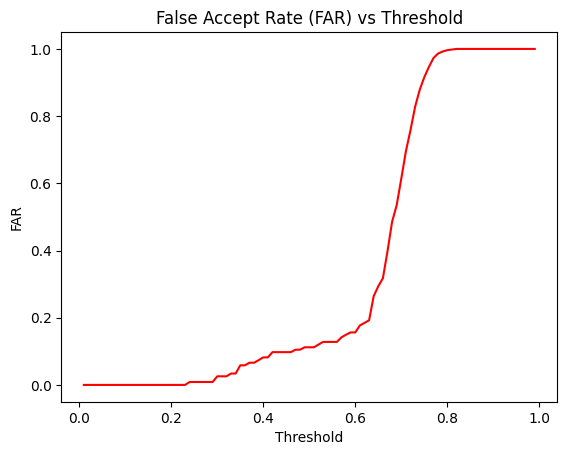

In [13]:
# Plot FAR against Thresholds
plt.figure()
plt.plot(thresholds, far_values, color='r')
plt.title('False Accept Rate (FAR) vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('FAR')
plt.show()

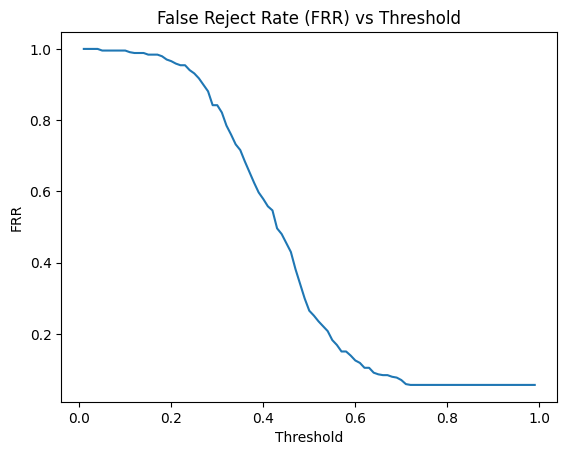

In [14]:
# Plot FAR against Thresholds
plt.figure()
plt.plot(thresholds, frr_values)
plt.title('False Reject Rate (FRR) vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('FRR')
plt.show()

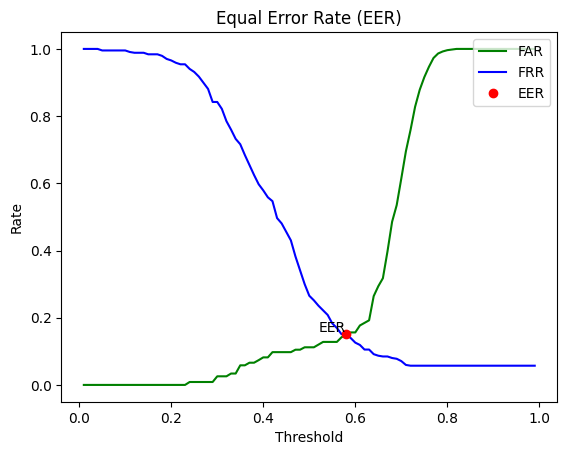

In [15]:
diffs = [abs(fa - fr) for fa, fr in zip(far_values, frr_values)]
eer_index = diffs.index(min(diffs))
eer_threshold = thresholds[eer_index]
eer_value = (far_values[eer_index] + frr_values[eer_index]) / 2

# Plot FAR and FRR against thresholds
plt.figure()
plt.plot(thresholds, far_values, color='g', label='FAR')
plt.plot(thresholds, frr_values, color='b', label='FRR')
plt.plot(eer_threshold, eer_value, 'ro', label='EER')
plt.text(eer_threshold, eer_value, 'EER', color='black', ha='right', va='bottom')

plt.title('Equal Error Rate (EER)')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend(loc='upper right')
plt.show()

In [42]:
eer_info = evaluation_metrics['thresholds'][eer_index]
print("Information at EER point:", eer_info)

Information at EER point:
{0.58: {'DI': 371, 'FA': 19, 'GR': 108, 'FR': 58, 'DIR': 0.8489702517162472, 'FRR': 0.15102974828375282, 'FAR': 0.14960629921259844, 'GRR': 0.8503937007874016}}


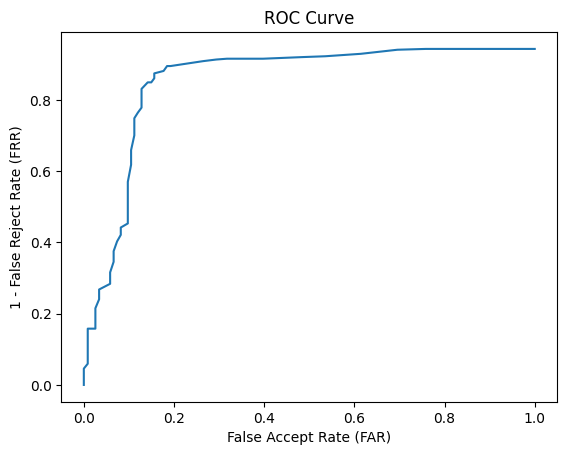

In [16]:
tpr_values = [1 - frr for frr in frr_values]  # TPR is 1 - FRR

plt.figure()
plt.plot(far_values, tpr_values)
plt.title('ROC Curve')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('1 - False Reject Rate (FRR)')
plt.show()

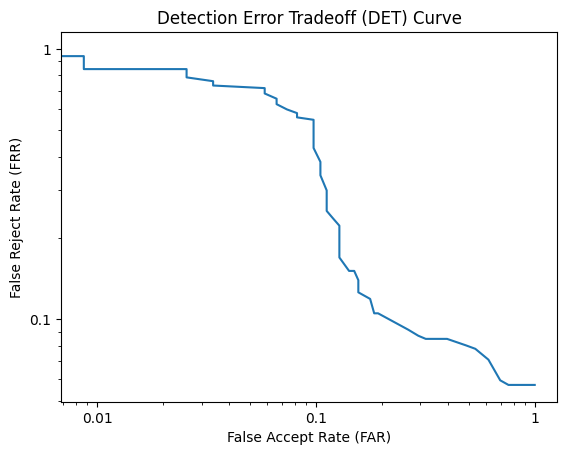

In [19]:
# Convert to numpy arrays if necessary
frr_values = np.array(frr_values)
far_values = np.array(far_values)

plt.figure()
plt.plot(far_values, frr_values, label='DET Curve')
plt.title('Detection Error Tradeoff (DET) Curve')

# Logarithmic scales for both axes
plt.xscale('log')
plt.yscale('log')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('False Reject Rate (FRR)')
plt.show()


In [44]:
'''
This function identifies the optimal threshold within a specified 
False Alarm Rate (FAR) range from a given set of evaluation metrics.
'''
def find_best_threshold_in_range(evaluation_metrics, criterion, min_far, max_far):
    best_threshold = None
    best_far = float('inf')
    info = None

    for threshold_entry in evaluation_metrics['thresholds']:
        threshold_value, threshold_data = list(threshold_entry.items())[0]
        far = threshold_data[criterion]

        if min_far <= far <= max_far and far < best_far:
            best_far = far
            best_threshold = float(threshold_value)
            info = threshold_data

    return best_threshold, info

min_far = 0.1
max_far = 0.2
best_threshold_in_range, info = find_best_threshold_in_range(evaluation_metrics, 'FAR', min_far, max_far)
print("Best threshold with FAR between", min_far, "and", max_far, ":", best_threshold_in_range, info)

Best threshold with FAR between 0.1 and 0.2 : 0.47 {'DI': 270, 'FA': 13, 'GR': 111, 'FR': 159, 'DIR': 0.6178489702517163, 'FRR': 0.38215102974828374, 'FAR': 0.10483870967741936, 'GRR': 0.8951612903225806}
